In [1]:
import json
import pandas as pd
from sklearn.preprocessing import StandardScaler

# Чтение данных из JSON файла
file_path = 'pm_vk_wall.json'  # путь к файлу
with open(file_path, 'r', encoding='utf-8') as f:
    vk_data = json.load(f)

# Создание списка для признаков
posts = []
for post in vk_data:
    # Извлечение нужных полей из постов
    posts.append({
        'likes_count': post.get('likes', {}).get('count', 0),
        'comments_count': post.get('comments', {}).get('count', 0),
        'reposts_count': post.get('reposts', {}).get('count', 0),
        'views_count': post.get('views', {}).get('count', 0),
        'attachments_count': len(post.get('attachments', [])),
        'text_length': len(post.get('text', '')),
        'has_attachments': 1 if post.get('attachments') else 0,
        'platform': post.get('post_source', {}).get('platform', 'unknown'),
        'is_donut': 1 if post.get('donut', {}).get('is_donut', False) else 0,
        'post_date': post.get('date', 0),
    })

# Преобразование данных в DataFrame
df = pd.DataFrame(posts)

# Нормализация числовых признаков (кроме категориальных, таких как платформа)
scaler = StandardScaler()
numerical_features = ['likes_count', 'comments_count', 'reposts_count', 'views_count', 'attachments_count', 'text_length', 'post_date']
df[numerical_features] = scaler.fit_transform(df[numerical_features])

# Отображение первых строк DataFrame
df.head()


,likes_count,comments_count,reposts_count,views_count,attachments_count,text_length,has_attachments,platform,is_donut,post_date
0,2.437374,0.489365,1.150825,0.937108,0.578613,-0.265111,1,iphone,0,1.141870
1,-0.907849,-0.238972,-0.134222,-0.476778,-0.201339,-0.274706,1,iphone,0,1.246122
2,-0.976119,-0.238972,-0.209813,-0.489247,-0.201339,0.028498,1,iphone,0,1.245750
3,-0.703040,-0.238972,0.092551,-0.378408,-0.201339,0.253023,1,iphone,0,1.245626
4,-0.634770,-0.238972,-0.209813,-0.272419,6.038279,-0.267030,1,iphone,0,1.236869


## Задание 2

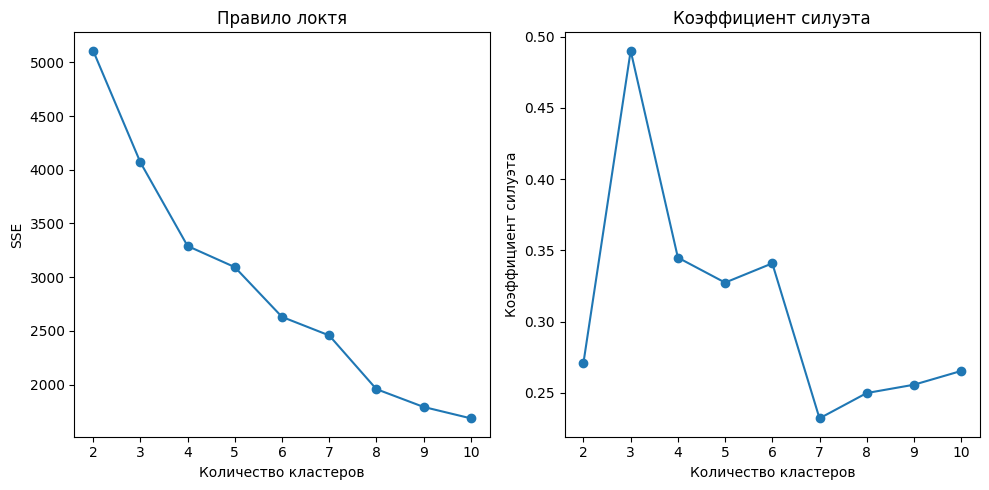

In [2]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder(sparse_output=False)

# Преобразуем категориальные данные в числовые
platform_encoded = encoder.fit_transform(df[['platform']])

# Получаем имена новых столбцов
platform_columns = encoder.get_feature_names_out(['platform'])

# Преобразуем результат в DataFrame и добавляем его к исходным данным
platform_df = pd.DataFrame(platform_encoded, columns=platform_columns)

# Объединяем новый DataFrame с закодированными платформами и основной DataFrame
df_encoded = pd.concat([df.drop('platform', axis=1), platform_df], axis=1)

# Определим диапазон количества кластеров, который будем проверять
cluster_range = range(2, 11)
sse = []  # Список для суммы квадратов ошибок (SSE)
silhouette_scores = []  # Список для коэффициентов силуэта

# Проход по разным значениям количества кластеров и сохранение метрик
for k in cluster_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(df_encoded)
    
    # SSE - сумма квадратов расстояний до ближайшего центра кластера
    sse.append(kmeans.inertia_)
    
    # Коэффициент силуэта
    labels = kmeans.labels_
    silhouette_scores.append(silhouette_score(df_encoded, labels))

# Построение графика "Правило локтя"
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(cluster_range, sse, marker='o')
plt.title('Правило локтя')
plt.xlabel('Количество кластеров')
plt.ylabel('SSE')

# Построение графика для коэффициента силуэта
plt.subplot(1, 2, 2)
plt.plot(cluster_range, silhouette_scores, marker='o')
plt.title('Коэффициент силуэта')
plt.xlabel('Количество кластеров')
plt.ylabel('Коэффициент силуэта')

plt.tight_layout()
plt.show()


# Задание 3

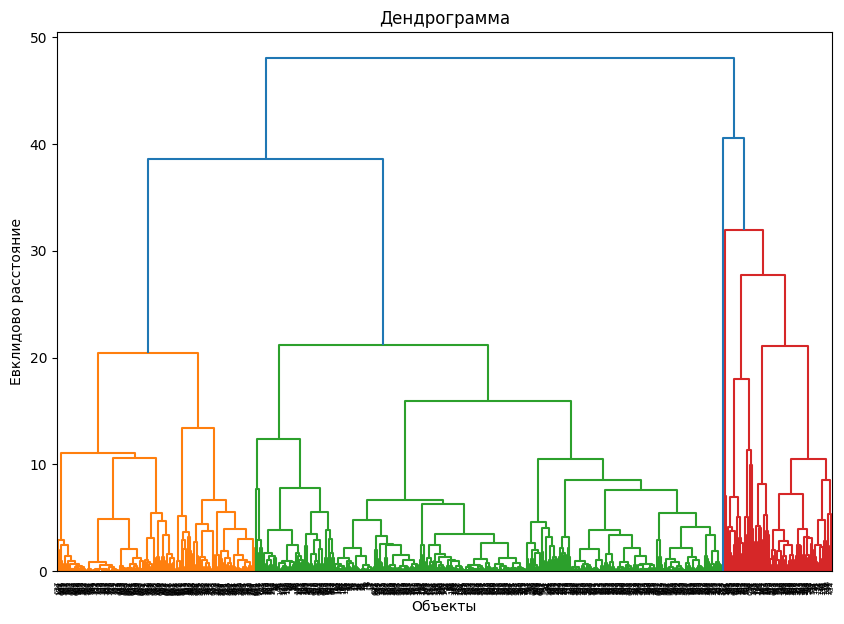

,likes_count,comments_count,reposts_count,views_count,attachments_count,text_length,has_attachments,is_donut,post_date,platform_android,platform_iphone,platform_unknown,cluster_hierarchical
0,2.437374,0.489365,1.150825,0.937108,0.578613,-0.265111,1,0,1.141870,0.0,1.0,0.0,0
1,-0.907849,-0.238972,-0.134222,-0.476778,-0.201339,-0.274706,1,0,1.246122,0.0,1.0,0.0,0
2,-0.976119,-0.238972,-0.209813,-0.489247,-0.201339,0.028498,1,0,1.245750,0.0,1.0,0.0,0
3,-0.703040,-0.238972,0.092551,-0.378408,-0.201339,0.253023,1,0,1.245626,0.0,1.0,0.0,0
4,-0.634770,-0.238972,-0.209813,-0.272419,6.038279,-0.267030,1,0,1.236869,0.0,1.0,0.0,1


In [4]:
import matplotlib.pyplot as plt
import scipy.cluster.hierarchy as sch
from sklearn.cluster import AgglomerativeClustering

# Построение дендрограммы для визуализации иерархической кластеризации
plt.figure(figsize=(10, 7))
dendrogram = sch.dendrogram(sch.linkage(df_encoded, method='ward'))
plt.title('Дендрограмма')
plt.xlabel('Объекты')
plt.ylabel('Евклидово расстояние')
plt.show()

# Выполним агломеративную кластеризацию с выбором оптимального количества кластеров (например, 3)
hc = AgglomerativeClustering(n_clusters=3, linkage='ward')
y_hc = hc.fit_predict(df_encoded)

# Добавим результат кластеризации в DataFrame
df_encoded['cluster_hierarchical'] = y_hc

# Выводим несколько первых строк для проверки
df_encoded.head()


# Задание 4

cluster_dbscan
 0     350
-1     293
 5      61
 7      33
 1      25
 2      15
 9      12
 3      11
 8      10
 4       7
 10      7
 6       5
Name: count, dtype: int64


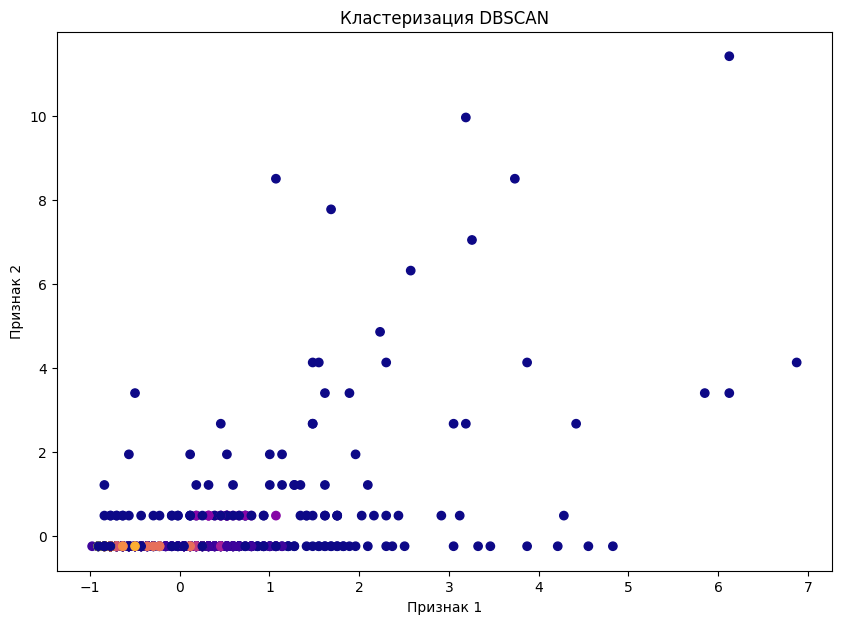

In [5]:
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Нормализуем данные перед использованием DBSCAN (если ещё не нормализовали)
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_encoded)

# Выполним кластеризацию DBSCAN с базовыми параметрами (значения eps и min_samples можно будет подстроить)
dbscan = DBSCAN(eps=0.5, min_samples=5)
y_dbscan = dbscan.fit_predict(df_scaled)

# Добавляем результаты в DataFrame
df_encoded['cluster_dbscan'] = y_dbscan

# Посмотрим на результаты
print(df_encoded['cluster_dbscan'].value_counts())

# Визуализируем результаты (предполагается, что данные двухмерные или могут быть преобразованы в двумерное пространство с помощью t-SNE/UMAP)
plt.figure(figsize=(10, 7))
plt.scatter(df_scaled[:, 0], df_scaled[:, 1], c=y_dbscan, cmap='plasma')
plt.title('Кластеризация DBSCAN')
plt.xlabel('Признак 1')
plt.ylabel('Признак 2')
plt.show()


# Задание 5

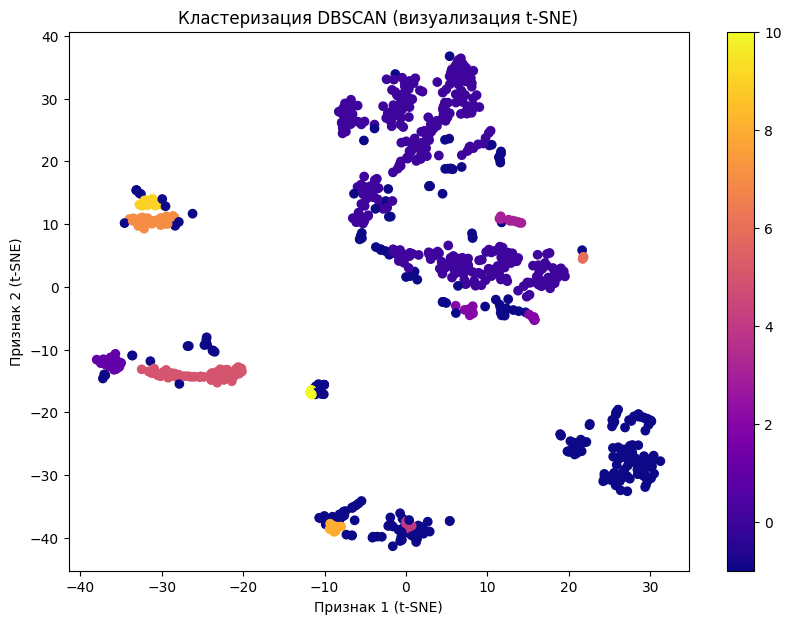

In [6]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Преобразуем данные в двумерное пространство с помощью t-SNE
tsne = TSNE(n_components=2, random_state=42)
df_tsne = tsne.fit_transform(df_scaled)  # Преобразуем нормализованные данные

# Визуализируем результаты кластеризации DBSCAN
plt.figure(figsize=(10, 7))
plt.scatter(df_tsne[:, 0], df_tsne[:, 1], c=y_dbscan, cmap='plasma')
plt.title('Кластеризация DBSCAN (визуализация t-SNE)')
plt.xlabel('Признак 1 (t-SNE)')
plt.ylabel('Признак 2 (t-SNE)')
plt.colorbar()
plt.show()
